In [1]:
import scipy.io as sio
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
import pathlib  # pathlib is in standard library
import pandas as pd

batch_size = 16
img_height = 224
img_width = 224

directory_train = "../input/ucfcc50/UCF_CC_50/" 
directory_mat_train = "../input/ucfcc50/UCF_CC_50/"
mat_path_ds_train = tf.data.Dataset.list_files(str(pathlib.Path(directory_mat_train + "*.mat")), seed=0)

In [2]:
count_train_l = []
file_path_train_l = []
for mat_path in mat_path_ds_train.as_numpy_iterator():
    mat_contents = sio.loadmat(mat_path)
    count = mat_contents['annPoints'].shape[0]
    id_img = int(str(mat_path).split('/')[-1].split('.')[0].split('_')[0])
    file_path = directory_train +str(id_img)+'.jpg'
    count_train_l.append(count)
    file_path_train_l.append(file_path)
print(f'training n. samples:{len(count_train_l)}')

training n. samples:50


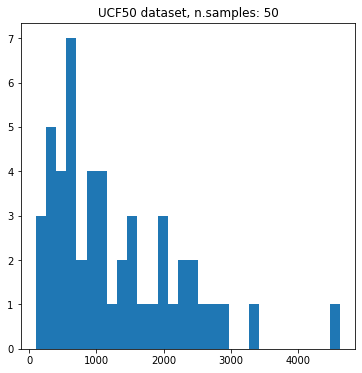

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
hist_fig = plt.figure(figsize=(6,6))
_ = plt.hist(count_train_l,bins=30)
_ = plt.title('UCF50 dataset, n.samples: '+str(len(file_path_train_l)))
plt.show()
_ = hist_fig.savefig('UCF50 dataset hist.png')

In [4]:
def process_path(file_path, count):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    
    return image, count

train_ds = tf.data.Dataset.from_tensor_slices((file_path_train_l, count_train_l))
train_ds = train_ds.map(process_path)
test_ds = tf.data.Dataset.from_tensor_slices((file_path_train_l, count_train_l))
test_ds = test_ds.map(process_path) #same as the training set

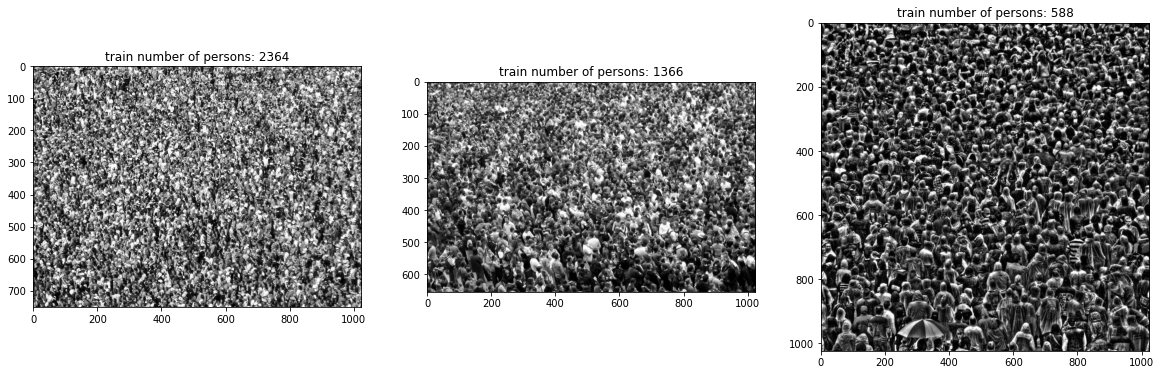

In [5]:
fig = plt.figure(figsize=(20,10))
for i, sample in enumerate(train_ds.take(3).as_numpy_iterator()):
    image = sample[0]
    _ = plt.subplot(1,3,i+1)
    _ = plt.imshow(image)
    _ = plt.title('train number of persons: '+ str(sample[1]))
plt.show()

In [6]:
resize_layer = tf.keras.layers.experimental.preprocessing.Resizing(height=img_height, width=img_width)
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1/255.)
flip_layer = tf.keras.layers.experimental.preprocessing.RandomFlip()
contrast_layer = tf.keras.layers.experimental.preprocessing.RandomContrast(0.3)
                                                                            
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda image,count: (normalization_layer((resize_layer(image))), count)).cache('./UCF50_training')
train_ds = train_ds.shuffle(buffer_size=100).batch(batch_size).map(lambda image,count: (contrast_layer(flip_layer(image)),count),
                                                                    num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda image,count: (normalization_layer((resize_layer(image))), count)).cache('./UCF50_test').batch(batch_size)

In [7]:
import sys
sys.path.append('../input/tempppp/')
from DenseNet import DenseNet121
model_121 = DenseNet121( input_shape = (img_height,img_width,3),
                                            include_top=False,
                                            pooling='avg',
                                          weights='imagenet'
                                         )
output = tf.keras.layers.Dense(1,
                               activation='relu',kernel_regularizer='l2')(model_121.output)
model_121 = tf.keras.Model(inputs=model_121.input, outputs=output)

29089792/29084464 [==============================] - 0s 0us/step


In [8]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath='./best_DenseNet121.h5', monitor='mae', verbose=1, save_best_only=True,
                save_weights_only=True, mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=8, min_lr=1e-6, verbose=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model_121.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
hist_121 = model_121.fit(train_ds,
                    epochs=200, verbose=2, callbacks=[ckpt_callback, reduce_lr])

Epoch 1/200
4/4 - 39s - loss: 2535387.2500 - mae: 1277.5812

Epoch 00001: mae improved from inf to 1277.58118, saving model to ./best_DenseNet121.h5
Epoch 2/200
4/4 - 25s - loss: 2496210.5000 - mae: 1261.8455

Epoch 00002: mae improved from 1277.58118 to 1261.84546, saving model to ./best_DenseNet121.h5
Epoch 3/200
4/4 - 25s - loss: 2442741.5000 - mae: 1239.8882

Epoch 00003: mae improved from 1261.84546 to 1239.88818, saving model to ./best_DenseNet121.h5
Epoch 4/200
4/4 - 25s - loss: 2373845.2500 - mae: 1214.1343

Epoch 00004: mae improved from 1239.88818 to 1214.13428, saving model to ./best_DenseNet121.h5
Epoch 5/200
4/4 - 26s - loss: 2287852.0000 - mae: 1183.3060

Epoch 00005: mae improved from 1214.13428 to 1183.30603, saving model to ./best_DenseNet121.h5
Epoch 6/200
4/4 - 26s - loss: 2188872.0000 - mae: 1150.7625

Epoch 00006: mae improved from 1183.30603 to 1150.76245, saving model to ./best_DenseNet121.h5
Epoch 7/200
4/4 - 26s - loss: 2125129.5000 - mae: 1115.7844

Epoch 0000

In [9]:
model_121.load_weights('./best_DenseNet121.h5')
model_121.evaluate(test_ds)

4/4 [==============================] - 7s 955ms/step - loss: 542737.1875 - mae: 514.9487


[542737.1875, 514.94873046875]

In [10]:
from DenseNet import DenseNet169
model_169 = DenseNet169( input_shape = (img_height,img_width,3),
                                            include_top=False,
                                            pooling='avg',
                                          weights='imagenet'
                                         )
output = tf.keras.layers.Dense(1,
                               activation='relu',kernel_regularizer='l2')(model_169.output)
model_169 = tf.keras.Model(inputs=model_169.input, outputs=output)

51879936/51877672 [==============================] - 1s 0us/step


In [11]:
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath='./best_DenseNet169.h5', monitor='mae', verbose=1, save_best_only=True,
                save_weights_only=True, mode='min')
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=8, min_lr=1e-6, verbose=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
model_169.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
hist_169 = model_169.fit(train_ds,
                    epochs=200, verbose=2, callbacks=[ckpt_callback, reduce_lr])

Epoch 1/200
4/4 - 49s - loss: 2520118.0000 - mae: 1271.3210

Epoch 00001: mae improved from inf to 1271.32104, saving model to ./best_DenseNet169.h5
Epoch 2/200
4/4 - 31s - loss: 2446657.5000 - mae: 1245.0414

Epoch 00002: mae improved from 1271.32104 to 1245.04138, saving model to ./best_DenseNet169.h5
Epoch 3/200
4/4 - 29s - loss: 2361745.0000 - mae: 1207.9753

Epoch 00003: mae improved from 1245.04138 to 1207.97534, saving model to ./best_DenseNet169.h5
Epoch 4/200
4/4 - 29s - loss: 2276319.5000 - mae: 1169.8247

Epoch 00004: mae improved from 1207.97534 to 1169.82471, saving model to ./best_DenseNet169.h5
Epoch 5/200
4/4 - 29s - loss: 2165252.2500 - mae: 1127.1575

Epoch 00005: mae improved from 1169.82471 to 1127.15747, saving model to ./best_DenseNet169.h5
Epoch 6/200
4/4 - 29s - loss: 2054500.0000 - mae: 1076.6616

Epoch 00006: mae improved from 1127.15747 to 1076.66162, saving model to ./best_DenseNet169.h5
Epoch 7/200
4/4 - 29s - loss: 1886657.7500 - mae: 1026.1675

Epoch 0000

In [12]:
model_169.load_weights('./best_DenseNet169.h5')
model_169.evaluate(test_ds)

4/4 [==============================] - 8s 1s/step - loss: 595168.8750 - mae: 519.2919


[595168.875, 519.2919311523438]

In [13]:
from DenseNet import CrowdCountingFPN
fpn_121 = CrowdCountingFPN().get_model()
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath='./best_FPN_121.h5', monitor='mae', verbose=1, save_best_only=True,
                save_weights_only=True, mode='min')


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=8, min_lr=1e-6, verbose=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
fpn_121.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
hist_fpn_121 = fpn_121.fit(train_ds,
                    epochs=200, verbose=2, callbacks=[ckpt_callback, reduce_lr])

Epoch 1/200
4/4 - 40s - loss: 2473661.2500 - mae: 1256.2406

Epoch 00001: mae improved from inf to 1256.24060, saving model to ./best_FPN_121.h5
Epoch 2/200
4/4 - 26s - loss: 1555951.8750 - mae: 926.5245

Epoch 00002: mae improved from 1256.24060 to 926.52448, saving model to ./best_FPN_121.h5
Epoch 3/200
4/4 - 26s - loss: 523446.2812 - mae: 515.6634

Epoch 00003: mae improved from 926.52448 to 515.66339, saving model to ./best_FPN_121.h5
Epoch 4/200
4/4 - 26s - loss: 690111.5000 - mae: 596.4380

Epoch 00004: mae did not improve from 515.66339
Epoch 5/200
4/4 - 25s - loss: 439692.7188 - mae: 477.8276

Epoch 00005: mae improved from 515.66339 to 477.82761, saving model to ./best_FPN_121.h5
Epoch 6/200
4/4 - 25s - loss: 705823.1250 - mae: 619.1208

Epoch 00006: mae did not improve from 477.82761
Epoch 7/200
4/4 - 25s - loss: 377383.3125 - mae: 418.6360

Epoch 00007: mae improved from 477.82761 to 418.63602, saving model to ./best_FPN_121.h5
Epoch 8/200
4/4 - 25s - loss: 474225.9062 - mae

In [14]:
fpn_121.load_weights('./best_FPN_121.h5')
fpn_121.evaluate(test_ds)

4/4 [==============================] - 6s 900ms/step - loss: 104501.4062 - mae: 233.5583


[104501.40625, 233.55828857421875]

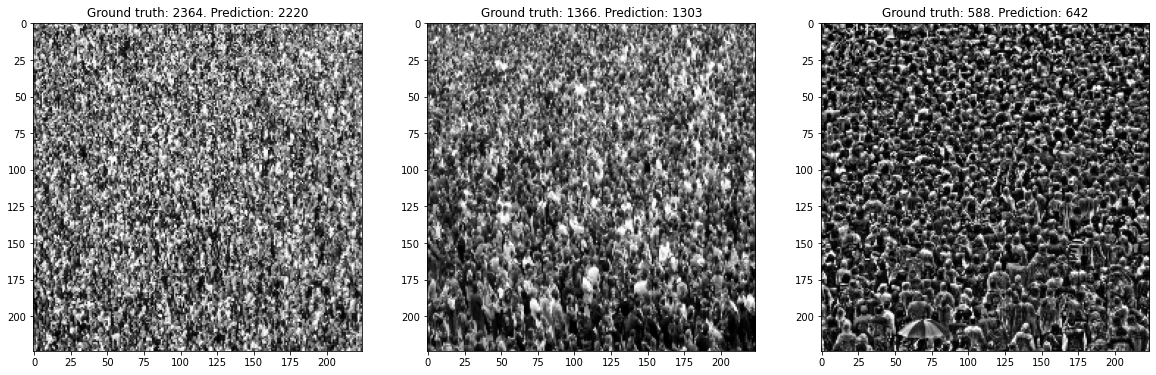

In [15]:
fig_pred = plt.figure(figsize=(20,10))

list_samples = list(test_ds.take(1).as_numpy_iterator())[0]
images = list_samples[0][:3]
labels = list_samples[1][:3]

labels_pred = fpn_121.predict(images).squeeze()

for i, image in enumerate(images):
    _ = plt.subplot(1,3,i+1)
    _ = plt.imshow(image)
    _ = plt.title('Ground truth: '+ str(labels[i])+'. Prediction: '+str(int(labels_pred[i])))
plt.show()
fig_pred.savefig('UCF50 fpn_121 prediction.png')

In [16]:
fpn_169 = CrowdCountingFPN(version='169').get_model()
ckpt_callback = tf.keras.callbacks.ModelCheckpoint(
                filepath='./best_FPN_169.h5', monitor='mae', verbose=1, save_best_only=True,
                save_weights_only=True, mode='min')


reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=8, min_lr=1e-6, verbose=1)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
fpn_169.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
hist_fpn_169 = fpn_169.fit(train_ds,
                    epochs=200, verbose=2, callbacks=[ckpt_callback, reduce_lr])

Epoch 1/200
4/4 - 49s - loss: 2488869.0000 - mae: 1261.5841

Epoch 00001: mae improved from inf to 1261.58411, saving model to ./best_FPN_169.h5
Epoch 2/200
4/4 - 30s - loss: 1615672.0000 - mae: 1013.5425

Epoch 00002: mae improved from 1261.58411 to 1013.54248, saving model to ./best_FPN_169.h5
Epoch 3/200
4/4 - 30s - loss: 433446.4375 - mae: 434.1072

Epoch 00003: mae improved from 1013.54248 to 434.10724, saving model to ./best_FPN_169.h5
Epoch 4/200
4/4 - 30s - loss: 425623.8125 - mae: 518.8535

Epoch 00004: mae did not improve from 434.10724
Epoch 5/200
4/4 - 30s - loss: 426956.1562 - mae: 448.6364

Epoch 00005: mae did not improve from 434.10724
Epoch 6/200
4/4 - 30s - loss: 343404.8750 - mae: 435.9631

Epoch 00006: mae did not improve from 434.10724
Epoch 7/200
4/4 - 30s - loss: 810162.6250 - mae: 693.9409

Epoch 00007: mae did not improve from 434.10724
Epoch 8/200
4/4 - 30s - loss: 756571.0625 - mae: 621.7727

Epoch 00008: mae did not improve from 434.10724
Epoch 9/200
4/4 - 3

In [17]:
fpn_169.load_weights('./best_FPN_169.h5')
fpn_169.evaluate(test_ds)

4/4 [==============================] - 9s 1s/step - loss: 134169.8906 - mae: 286.6618


[134169.890625, 286.66180419921875]

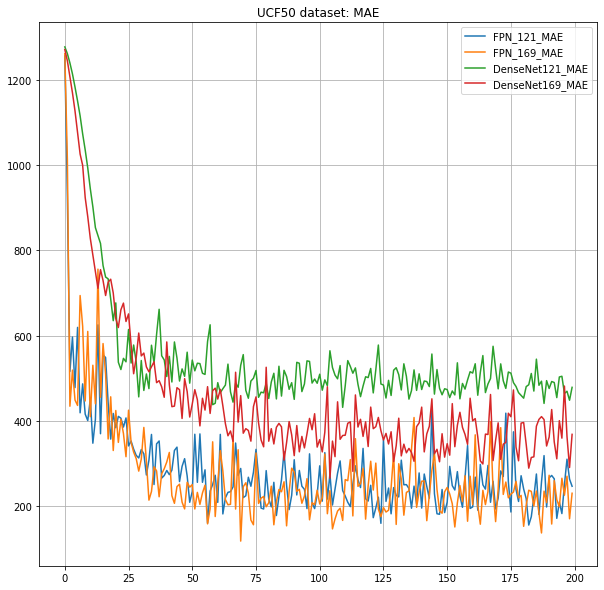

In [18]:
fig_train = plt.figure(figsize=(10,10))
plt.plot(hist_fpn_121.history['mae'], label='FPN_121_MAE')
plt.plot(hist_fpn_169.history['mae'], label='FPN_169_MAE')
plt.plot(hist_121.history['mae'], label='DenseNet121_MAE')
plt.plot(hist_169.history['mae'], label='DenseNet169_MAE')
plt.legend()
plt.grid()
plt.title('UCF50 dataset: MAE')

plt.show()
fig_train.savefig('UCF50 train plots.png')